In [3]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Import the directory of csv file
data = pd.read_csv(
    r"Sample_Commercial_Buildings.csv",
    index_col=0, encoding='utf-8')

In [6]:
data = data[(data.highrise > 0) | (data.podium > 0)]

In [7]:
# Building Height
data['Area'] = np.where(data['highrise'] == 1, data['area_upper'], data['area_podium'])

In [8]:
# Building Retrofitting due to Energy Audit Policy (Before and After)
data['retro_before_audit'] = np.where(data['retro'] == 'retro_before', 1, 0)  # np.where(condition, x, y)
data['retro_after_audit'] = np.where(data['retro'] == 'retro_after', 1, 0)  # np.where(condition, x, y)

In [9]:
# Year of Building Construction
data.loc[data['Year'] < 1950, 'year_built'] = 1
data.loc[(data['Year'] >= 1950) & (data['Year'] < 1960), 'year_built'] = 2
data.loc[(data['Year'] >= 1960) & (data['Year'] < 1970), 'year_built'] = 3
data.loc[(data['Year'] >= 1970) & (data['Year'] < 1980), 'year_built'] = 4
data.loc[(data['Year'] >= 1980) & (data['Year'] < 1990), 'year_built'] = 5
data.loc[(data['Year'] >= 1990) & (data['Year'] < 2000), 'year_built'] = 6
data.loc[(data['Year'] >= 2000) & (data['Year'] < 2010), 'year_built'] = 7
data.loc[data['Year'] >= 2010, 'year_built'] = 8

In [10]:
# Log10 transformation of Building Footprint
data['log10_footprint'] = np.log10(data['Area'] + 1)  # building footprint 
#data['BV'] = np.log10(data['BV'] + 1)
#data['ndbi'] = np.log10(data['ndbi'] + 1)
data['NDVI'] = np.log10(data['ndvi'] + 1)

In [11]:
# # Log10 transformation of Kernel Density
data['log10_hotel'] = np.log10(data['hotel'] + 1)
data['log10_retail'] = np.log10(data['retail'] + 1)
data['log10_carparking'] = np.log10(data['parking']+ 1)
data['log10_food'] = np.log10(data['food']+ 1)
data['log10_office'] = np.log10(data['office'] + 1)

In [12]:
# Distance to MTR Transit Station
data['log10_metro_dist'] = np.log10(data['Dist_mtr'])  # the distance between commercial building and MTR
# Only COMMERCIAL land use is considered (11)
data['commercial_land_use'] = np.where(data['landuse'] == 11, 1, 0)

In [13]:
# Air condition System  # Haven't mentioned in paper (individual and central)
data['individual_AC'] = np.where(data['AC_type'] == 'Individual Air-Conditioning System', 1, 0)  
data['central_AC'] = np.where(data['AC_type'] == 'Central Air-Conditioning System', 1, 0)

In [14]:
# Number of Lift in a certain building
data['no_lifts'] = data['Passage_lift'] + data['Service_lift']  # Number of Lift = Passenger + Service
no_lifts_percentile = np.nanpercentile(data['no_lifts'], [50, 75])  # 50-75% Lifts
data['no_lifts_c'] = np.where(data['no_lifts'] < no_lifts_percentile[0], "no_lifts_50%below",
                              (np.where(data['no_lifts'] < no_lifts_percentile[1], "no_lifts_50%_75%",
                                        np.where(pd.isna(data['no_lifts']), np.NaN, "no_lifts_75%above"))))  # no value--> 75%

In [15]:
# <50%, 50% to 75%, >75%
data['no_lifts_50%below'] = np.where(data['no_lifts_c'] == 'no_lifts_50%below', 1, 0)
data['no_lifts_50%_75%'] = np.where(data['no_lifts_c'] == 'no_lifts_50%_75%', 1, 0)
data['no_lifts_75%above'] = np.where(data['no_lifts_c'] == 'no_lifts_75%above', 1, 0)

In [16]:
# Building Operation Time
data['operate_start_before8'] = np.where(data['Operate_start_work'] < 8, 1, 0)
data['operate_start_8_9'] = np.where(((data['Operate_start_work'] >= 8) & (data['Operate_start_work'] < 9)), 1, 0)
data['operate_start_9_10'] = np.where(((data['Operate_start_work'] >= 9) & (data['Operate_start_work'] < 10)), 1, 0)
data['operate_start_after10'] = np.where(data['Operate_start_work'] >= 10, 1, 0)

In [17]:
Operate_hours_percentile = np.nanpercentile(data['Operate_hours'], [25, 50, 75])
data['operate_hours_c'] = np.where(data['Operate_hours'] < Operate_hours_percentile[0], 'Operate_hours_25%', # <25%
                                   (np.where(data['Operate_hours'] < Operate_hours_percentile[1], 'Operate_hours_50%',  # <50%
                                             (np.where(data['Operate_hours'] < Operate_hours_percentile[2], 'Operate_hours_75%',  # <75%
                                                       (np.where(pd.isna(data['Operate_hours']), np.NaN, 'Operate_hours_100%')))))))  # detect missing data

In [18]:
data['operate_hours_25%'] = np.where(data['operate_hours_c'] == 'Operate_hours_25%', 1, 0)
data['operate_hours_50%'] = np.where(data['operate_hours_c'] == 'Operate_hours_50%', 1, 0)
data['operate_hours_75%'] = np.where(data['operate_hours_c'] == 'Operate_hours_75%', 1, 0)
data['operate_hours_100%'] = np.where(data['operate_hours_c'] == 'Operate_hours_100%', 1, 0)

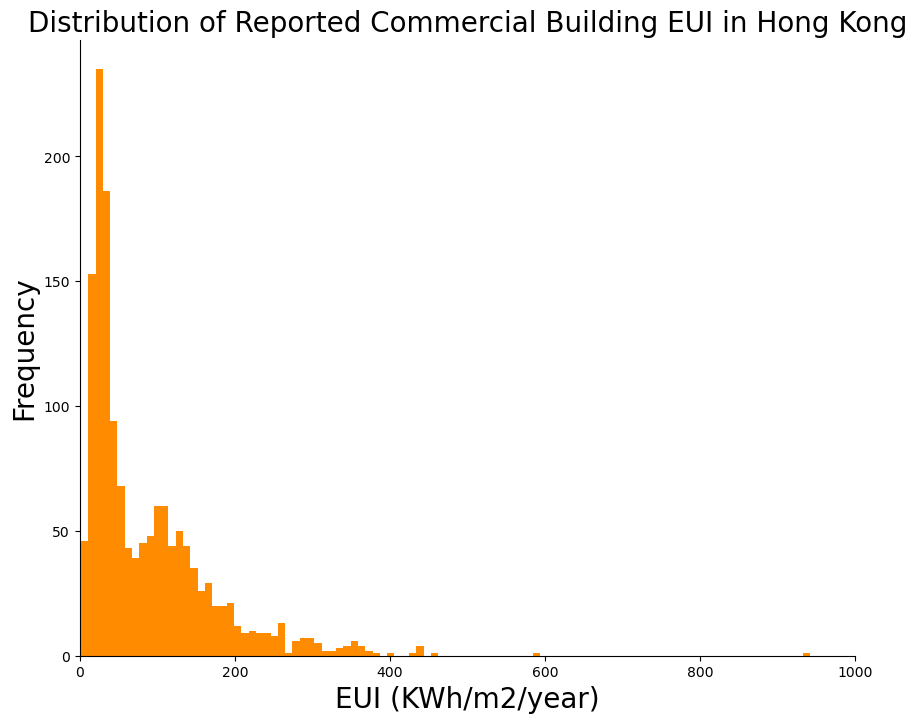

In [19]:
# Building Energy Usage Intensity
y1 = data['bld_eui2']
fig, ax = plt.subplots(figsize=(10,8))
plt.hist((y1), bins = 100, color = 'darkorange')
plt.ylabel('Frequency',fontsize = 20)
plt.xlabel("EUI (KWh/m2/year)",fontsize = 20)
plt.title("Distribution of Reported Commercial Building EUI in Hong Kong",fontsize = 20)
# Hide the right and top spines
ax.set_xlim([0,1000])  # The range of Y axis
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

In [21]:
# Building Energy Usage Intensity
log_eui = np.log10(data['bld_eui2'])
log_eui_median = log_eui.median()  # Compute the Median of Building EUI

In [22]:
log_eui_median

1.7269715836828767

In [23]:
# If a building is below the median,it means it is low EUI. Otherwise, it is considered as high EUI
#data['bld_eui2_label'] = np.where(np.log10(data['bld_eui2']) < log_eui_median, "low", "high")
data['bld_eui2_label'] = np.where(np.log10(data['bld_eui2']) < 1.7269715836828767, "low", "high")

In [24]:
y = data['bld_eui2_label'].reset_index(drop=True)

In [25]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(['low','high'])
ylabel = le.transform(y)

1.749856622787119 0.4158091866375914


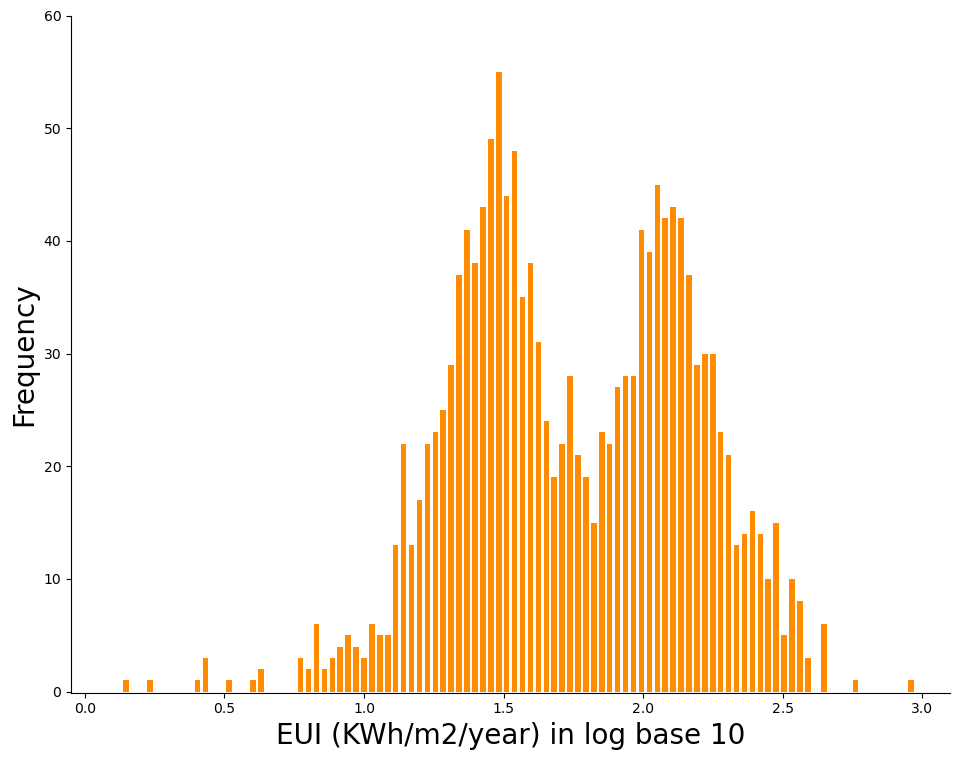

In [26]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from numpy.random import normal
from numpy import hstack
from numpy import asarray
from numpy import exp
from sklearn.neighbors import KernelDensity
from scipy.stats import norm
import pandas

y1 = data['bld_eui2']
mu = np.mean(np.log10(y1))
print(np.mean(np.log10(y1)),np.std(np.log10(y1)))
sigma =np.std(np.log10(y1))
mu,sigma

fig, ax = plt.subplots(figsize=(10,8))
#ax = fig.add_subplot(111)

plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 20
plt.ylabel('Frequency',fontsize = 20)
plt.xlabel("EUI (KWh/m2/year) in log base 10",fontsize = 20)
#plt.title("Distribution of Reported Commercial Building EUI in Hong Kong\n(After Log10 Transformation)",fontsize = 20)

#plt.axvline(x = 1.7269715836828767, color='black', linestyle='--') 
plt.hist(np.log10(y1), bins = 100, color = 'darkorange', rwidth=0.7)
plt.subplots_adjust(left=0.25)
ax.set_xlim([-0.05, 3.1])  # The range of X axis
ax.set_ylim([-0.1,60])  # The range of Y axis
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

In [392]:
# X 

# X1+X2+X3+X4........+Xn
X = data[[
          'log10_footprint', 
          'BS',
          'year_built',
          'log10_hotel', 
          'log10_carparking', 
          'log10_food', 
          'log10_office',
          'log10_retail',
          'CDH',
          'wind_speed_10m',
          'GHI',
          'retro_before_audit', 
          'retro_after_audit',
          'log10_metro_dist',
          'commercial_land_use',
          'individual_AC',
          'central_AC',
          'no_lifts_50%below', 
          'no_lifts_50%_75%', 
          'no_lifts_75%above',
          'operate_start_before8', 
          'operate_start_8_9',
          'operate_start_9_10', 
          'operate_start_after10',
          'operate_hours_25%', 
          'operate_hours_50%', 
          'operate_hours_75%', 
          'operate_hours_100%',
         'NDVI',
         'BH',
          ]].reset_index(drop=True)

In [178]:
X

,log_area,Storey,Year_built_class,log_hotel,log_parking,log_food,log_office,log_retail,td_cdd,wind10m,...,Operate_start_before8,Operate_start_8_9,Operate_start_9_10,Operate_start_after10,Operate_hours_25%,Operate_hours_50%,Operate_hours_75%,Operate_hours_100%,ndvi,BH
0,2.060698,5,4.0,1.890600,1.748245,2.750192,0.000000,2.704174,2.50708,3.10741,...,0,0,0,0,0,0,0,0,0.003396,37.538166
1,2.519828,13,4.0,0.000000,2.425565,2.249458,0.000000,3.067402,2.72197,2.29804,...,0,0,0,0,0,0,0,0,0.038056,39.309444
2,2.660865,36,7.0,0.000000,1.952572,1.744457,0.000000,2.345632,2.50708,2.09989,...,0,0,0,0,0,0,0,0,0.052051,161.831970
3,2.320146,21,4.0,0.000000,1.568914,2.851846,2.516849,3.165167,2.68616,2.43564,...,0,0,0,0,0,0,0,0,0.000613,75.504829
4,2.230449,7,4.0,1.954109,0.000000,2.555555,0.000000,2.773442,2.90105,2.50368,...,0,0,0,0,0,0,0,0,0.103458,30.511705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,3.176381,22,5.0,2.229416,2.051565,2.960001,0.000000,2.782170,2.79360,2.37091,...,0,0,0,0,0,0,0,0,0.068834,22.569948
1192,3.526727,46,5.0,0.000000,1.042879,2.190889,2.766011,0.149559,2.50708,2.51164,...,0,0,0,0,0,0,0,0,0.021036,81.159958
1193,2.068186,15,6.0,0.000000,1.874156,3.023569,2.986979,2.550964,2.68616,2.94447,...,0,0,0,0,0,0,0,0,0.119153,51.133446
1194,2.346353,14,5.0,0.000000,1.773042,2.629082,2.808663,2.870126,2.65034,2.47397,...,0,0,0,0,0,0,0,0,0.050393,51.767632


In [136]:
y

0        low
1        low
2        low
3        low
4        low
        ... 
1490    high
1491    high
1492    high
1493    high
1494    high
Name: bld_eui2_label, Length: 1495, dtype: object

In [393]:
# Random Forest
import numpy as np
seed = 8000
rf = RandomForestClassifier(random_state=seed)

n_estimators = [int(x) for x in np.linspace(start=10, stop=500, num=50)]
max_features = ['auto', 'sqrt', 'log2'] 
max_depth = [int(x) for x in np.linspace(3, 10, num=20)]
max_depth.append(None)
min_samples_split = [8, 10, 12, 14, 16, 18, 20, 30]
min_samples_leaf = [4, 6, 8]
bootstrap = [True, False]
criterion = ['gini', 'entropy']

parameter_dis = {'n_estimators': n_estimators,  # number of trees in the forest
                 'max_features': max_features,
                 'max_depth': max_depth,
                 'min_samples_split': min_samples_split,
                 'min_samples_leaf': min_samples_leaf,
                 'bootstrap': bootstrap,
                 'criterion': criterion}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=parameter_dis,
                               n_iter=200, cv=5, verbose=1, n_jobs=-1, scoring='accuracy', refit=False)
rf_random.fit(X, y)

# Selecting the best parameter
best_params_ = rf_random.best_params_

# Random Forest Classification
rf = RandomForestClassifier(random_state=seed,
                            n_estimators=best_params_['n_estimators'],
                            min_samples_split=best_params_['min_samples_split'],
                            min_samples_leaf=best_params_['min_samples_leaf'],
                            max_features=best_params_['max_features'],
                            max_depth=best_params_['max_depth'],
                            bootstrap=best_params_['bootstrap'],
                            criterion=best_params_['criterion'])

cv = KFold(n_splits=5, random_state=seed, shuffle=True)
for (train, test), i in zip(cv.split(X, y), range(5)):
    rf.fit(X.iloc[train], y.iloc[train])
    y_pred = rf.predict(X.iloc[test])
    print(metrics.classification_report(y.iloc[test], y_pred, digits=4))
    print("--------------------------------- Random Forest Result ----------------------------------------")
    print(rf.score(X.iloc[test], y.iloc[test]))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
              precision    recall  f1-score   support

        high     0.8644    0.8430    0.8536       121
         low     0.8443    0.8655    0.8548       119

    accuracy                         0.8542       240
   macro avg     0.8543    0.8543    0.8542       240
weighted avg     0.8544    0.8542    0.8542       240

--------------------------------- Random Forest Result ----------------------------------------
0.8541666666666666
              precision    recall  f1-score   support

        high     0.7760    0.8362    0.8050       116
         low     0.8333    0.7724    0.8017       123

    accuracy                         0.8033       239
   macro avg     0.8047    0.8043    0.8033       239
weighted avg     0.8055    0.8033    0.8033       239

--------------------------------- Random Forest Result ----------------------------------------
0.803347280334728
              precision    recall  f1-score   support

In [536]:
prediction = pd.DataFrame(y_pred, columns=['predictions']).to_csv('prediction.csv')
test = pd.DataFrame(test, columns=['test']).to_csv('test.csv')

In [394]:
# XGBoost
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb

data_matrix = xgb.DMatrix(data=X, label=ylabel)

# set the prarameter 
space = {'max_depth': hp.quniform("max_depth", 3, 10, 1),
         'learning_rate': hp.uniform("learning_rate", 0.05, 0.3),
         'colsample_bytree': hp.uniform("colsample_bytree", 0.5, 1),
         'min_child_weight': hp.quniform("min_child_weight", 1, 20, 1),
         'reg_alpha': hp.quniform("reg_alpha", 0, 100, 1),
         'reg_lambda': hp.uniform("reg_lambda", 0, 2),
         'subsample': hp.uniform("subsample", 0.5, 1),
         'min_split_loss': hp.uniform("min_split_loss", 0, 9),
         'rate_drop': hp.uniform("rate_drop", 0, 1)}


def fobjective(space):
    param_dict_tunning = {'max_depth': int(space['max_depth']),
                          'learning_rate': space['learning_rate'],
                          'colsample_bytree': space['colsample_bytree'],
                          'min_child_weight': int(space['min_child_weight']),
                          'reg_alpha': int(space['reg_alpha']),
                          'reg_lambda': space['reg_lambda'],
                          'subsample': space['subsample'],
                          'min_split_loss': space['min_split_loss'],
                          'booster': 'gbtree',
                          # 'rate_drop': space['rate_drop'],
                          'objective': 'binary:logistic'}
    xgb_cv_result = xgb.cv(dtrain=data_matrix, params=param_dict_tunning, nfold=5, early_stopping_rounds=30,
                           as_pandas=True, num_boost_round=200, seed=8000, metrics='error')

    return {"loss": (xgb_cv_result["test-error-mean"]).tail(1).iloc[0], "status": STATUS_OK}


trials = Trials()
best_hyperparams = fmin(fn=fobjective, space=space, algo=tpe.suggest, max_evals=200, trials=trials)

param_dict_tunning = {'objective': 'binary:logistic', 'eval_metric': 'error',
                      'max_depth': int(best_hyperparams['max_depth']),
                      'reg_alpha': best_hyperparams['reg_alpha'], 'reg_lambda': best_hyperparams['reg_lambda'],
                      'min_child_weight': best_hyperparams['min_child_weight'],
                      'colsample_bytree': best_hyperparams['colsample_bytree'],
                      'learning_rate': best_hyperparams['learning_rate'], 'subsample': best_hyperparams['subsample'],
                      'min_split_loss': best_hyperparams['min_split_loss'],
                      # 'rate_drop':best_hyperparams['rate_drop'],
                      'booster': 'gbtree'}

for train, test in KFold(n_splits=5, shuffle=True, random_state=8000).split(X, ylabel):
    input_matrix = xgb.DMatrix(data=X.loc[train], label=ylabel[train])
    test_matrix = xgb.DMatrix(data=X.loc[test], label=ylabel[test])
    watchlist = [(test_matrix, 'eval'), (input_matrix, 'train')]

    xgb_model = xgb.train(params=param_dict_tunning, dtrain=input_matrix, num_boost_round=200, evals=watchlist,
                          xgb_model=None, verbose_eval=False, early_stopping_rounds=30)

    y_pred_pro = xgb_model.predict(test_matrix)
    y_pred = [round(value) for value in y_pred_pro]
    y_true = ylabel[test]
    print("----------------------------------------- XGBoost Result -------------------------------------------------")
    print(metrics.classification_report(y_true, y_pred, digits=4))

  0%|                                                                          | 0/200 [00:00<?, ?trial/s, best loss=?]

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


100%|█████████████████████████████████████████████| 200/200 [00:48<00:00,  4.10trial/s, best loss: 0.19317639999999997]
----------------------------------------- XGBoost Result -------------------------------------------------
              precision    recall  f1-score   support

           0     0.8031    0.8430    0.8226       121
           1     0.8319    0.7899    0.8103       119

    accuracy                         0.8167       240
   macro avg     0.8175    0.8164    0.8165       240
weighted avg     0.8174    0.8167    0.8165       240



pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


----------------------------------------- XGBoost Result -------------------------------------------------
              precision    recall  f1-score   support

           0     0.7934    0.8276    0.8101       116
           1     0.8305    0.7967    0.8133       123

    accuracy                         0.8117       239
   macro avg     0.8119    0.8122    0.8117       239
weighted avg     0.8125    0.8117    0.8117       239

----------------------------------------- XGBoost Result -------------------------------------------------
              precision    recall  f1-score   support

           0     0.8189    0.8189    0.8189       127
           1     0.7946    0.7946    0.7946       112

    accuracy                         0.8075       239
   macro avg     0.8068    0.8068    0.8068       239
weighted avg     0.8075    0.8075    0.8075       239



pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


----------------------------------------- XGBoost Result -------------------------------------------------
              precision    recall  f1-score   support

           0     0.8000    0.7395    0.7686       119
           1     0.7597    0.8167    0.7871       120

    accuracy                         0.7782       239
   macro avg     0.7798    0.7781    0.7779       239
weighted avg     0.7798    0.7782    0.7779       239

----------------------------------------- XGBoost Result -------------------------------------------------
              precision    recall  f1-score   support

           0     0.8158    0.6838    0.7440       136
           1     0.6560    0.7961    0.7193       103

    accuracy                         0.7322       239
   macro avg     0.7359    0.7400    0.7316       239
weighted avg     0.7469    0.7322    0.7334       239



pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [601]:
prediction_xgb = pd.DataFrame(y_pred, columns=['predictions']).to_csv('prediction_xgb.csv')
test_xgb = pd.DataFrame(test, columns=['test']).to_csv('test_xgb.csv')
lable_xgb = pd.DataFrame(ylabel[test], columns=['lable']).to_csv('lable_xgb.csv')

In [395]:
# Deep learning
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
import wrapt

seed = 8000

input_scaler = MinMaxScaler()
input_scaler.fit(X)
X_normalized = input_scaler.transform(X)

model = Sequential()
model.add(Dense(24, input_dim=len(X.iloc[0]), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

cv = KFold(n_splits=5, random_state=seed, shuffle=True)
for (train, test), i in zip(cv.split(X_normalized, ylabel), range(5)):
    model.fit(X_normalized[train], ylabel[train], epochs=150, batch_size=1024, verbose=0)

    y_pred_pro = model.predict(X_normalized[test], batch_size=1024, verbose=0)
    y_pred = np.round(y_pred_pro)
    print("----------------------------------- Deep Learning Result -------------------------------------------------")
    print(metrics.classification_report(ylabel[test], y_pred, digits=4))

     #accuracy = model.evaluate(X_normalized[test], ylabel[test],batch_size=1024,verbose=0)
     #print('Accuracy: %.2f' % (accuracy*100))

----------------------------------- Deep Learning Result -------------------------------------------------
              precision    recall  f1-score   support

           0     0.8435    0.8017    0.8220       121
           1     0.8080    0.8487    0.8279       119

    accuracy                         0.8250       240
   macro avg     0.8257    0.8252    0.8250       240
weighted avg     0.8259    0.8250    0.8249       240

----------------------------------- Deep Learning Result -------------------------------------------------
              precision    recall  f1-score   support

           0     0.8214    0.7931    0.8070       116
           1     0.8110    0.8374    0.8240       123

    accuracy                         0.8159       239
   macro avg     0.8162    0.8153    0.8155       239
weighted avg     0.8161    0.8159    0.8158       239

----------------------------------- Deep Learning Result -------------------------------------------------
              precision  

In [596]:
prediction_dp = pd.DataFrame(y_pred, columns=['predictions']).to_csv('prediction_dp.csv')
test_dp = pd.DataFrame(test).to_csv('test_dp.csv')
lable_dp = pd.DataFrame(ylabel[test], columns=['lable']).to_csv('lable_dp.csv')

In [396]:
# Support vector machine
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

seed = 8000

input_scaler = MinMaxScaler()
input_scaler.fit(X)
X_normalized = input_scaler.transform(X)

param_SVC = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'poly', 'sigmoid']}

SVC_grid = GridSearchCV(SVC(), param_SVC, refit=False, verbose=0, cv=5, scoring='accuracy')
SVC_grid.fit(X_normalized, ylabel)

SVC_model = SVC(**SVC_grid.best_params_)

cv = KFold(n_splits=5, random_state=seed, shuffle=True)
for (train, test), i in zip(cv.split(X_normalized, ylabel), range(5)):
    SVC_model.fit(X_normalized[train], y[train])

    y_pred = SVC_model.predict(X_normalized[test])
    print("--------------------------------------------- SVM Result -------------------------------------------------")
    print(metrics.classification_report(y[test], y_pred, digits=4))

    print(SVC_model.score(X_normalized[test], y[test]))

--------------------------------------------- SVM Result -------------------------------------------------
              precision    recall  f1-score   support

        high     0.8857    0.7686    0.8230       121
         low     0.7926    0.8992    0.8425       119

    accuracy                         0.8333       240
   macro avg     0.8392    0.8339    0.8328       240
weighted avg     0.8395    0.8333    0.8327       240

0.8333333333333334
--------------------------------------------- SVM Result -------------------------------------------------
              precision    recall  f1-score   support

        high     0.8302    0.7586    0.7928       116
         low     0.7895    0.8537    0.8203       123

    accuracy                         0.8075       239
   macro avg     0.8098    0.8061    0.8066       239
weighted avg     0.8092    0.8075    0.8070       239

0.8075313807531381
--------------------------------------------- SVM Result -------------------------------------

In [397]:
########################################################################################################################
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

params_NB = {'var_smoothing': np.logspace(0, -9, num=100)}

NB_grid = GridSearchCV(GaussianNB(), param_grid=params_NB, cv=5, verbose=0, scoring='accuracy')
NB_grid.fit(X, ylabel)

NB_model = GaussianNB(**NB_grid.best_params_)

cv = KFold(n_splits=5, random_state=seed, shuffle=True)
for (train, test), i in zip(cv.split(X, ylabel), range(5)):
    NB_model.fit(X.iloc[train], y[train])
    y_pred = NB_model.predict(X.iloc[test])
    print("------------------------------------- Native Bayes Result -------------------------------------------------")
    print(metrics.classification_report(y.iloc[test], y_pred, digits=4))
    print(NB_model.score(X.iloc[test], y[test]))

------------------------------------- Native Bayes Result -------------------------------------------------
              precision    recall  f1-score   support

        high     0.9032    0.6942    0.7850       121
         low     0.7483    0.9244    0.8271       119

    accuracy                         0.8083       240
   macro avg     0.8258    0.8093    0.8061       240
weighted avg     0.8264    0.8083    0.8059       240

0.8083333333333333
------------------------------------- Native Bayes Result -------------------------------------------------
              precision    recall  f1-score   support

        high     0.8495    0.6810    0.7560       116
         low     0.7466    0.8862    0.8104       123

    accuracy                         0.7866       239
   macro avg     0.7980    0.7836    0.7832       239
weighted avg     0.7965    0.7866    0.7840       239

0.7866108786610879
------------------------------------- Native Bayes Result ----------------------------------

In [398]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(max_iter=500)

cv = KFold(n_splits=5, random_state=seed, shuffle=True)

for (train, test), i in zip(cv.split(X, ylabel), range(5)):
    logit.fit(X.iloc[train], ylabel[train])
    y_pred = logit.predict(X.iloc[test])
    print("--------------------------------- Logistic Regression Result ----------------------------------------")
    print(metrics.classification_report(ylabel[test], y_pred, digits=4))
    print("--------------------------------- Logistic Regression Result ----------------------------------------")
    print(logit.score(X.iloc[test], ylabel[test]))

--------------------------------- Logistic Regression Result ----------------------------------------
              precision    recall  f1-score   support

           0     0.8443    0.8512    0.8477       121
           1     0.8475    0.8403    0.8439       119

    accuracy                         0.8458       240
   macro avg     0.8459    0.8458    0.8458       240
weighted avg     0.8458    0.8458    0.8458       240

--------------------------------- Logistic Regression Result ----------------------------------------
0.8458333333333333
--------------------------------- Logistic Regression Result ----------------------------------------
              precision    recall  f1-score   support

           0     0.7982    0.7845    0.7913       116
           1     0.8000    0.8130    0.8065       123

    accuracy                         0.7992       239
   macro avg     0.7991    0.7987    0.7989       239
weighted avg     0.7991    0.7992    0.7991       239

---------------------

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


100%|===================| 2980/2990 [00:47<00:00]        

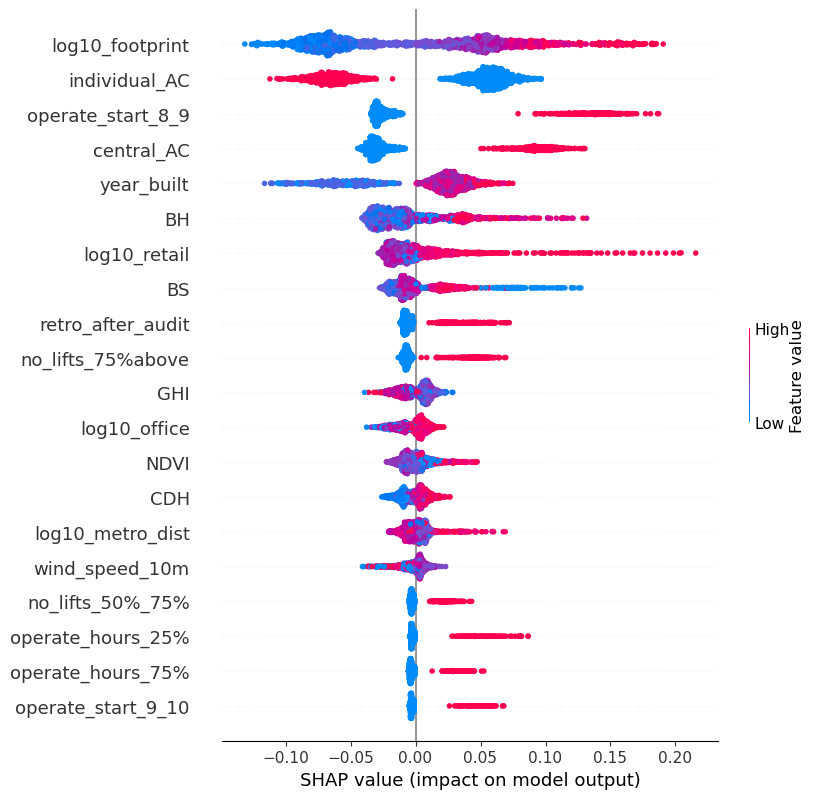

In [350]:
# Shapley Value
import shap
import sklearn
from sklearn.ensemble import RandomForestRegressor

explainer = shap.TreeExplainer(rf, X, model_output='probability')
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values[0], X)

plt.show()

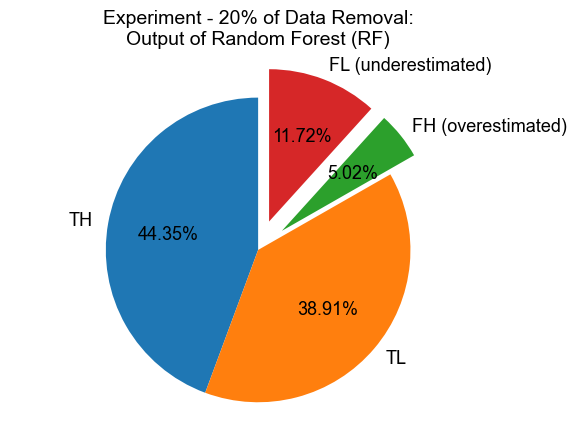

<Figure size 1920x1440 with 0 Axes>

In [237]:
plt.rcParams["font.family"] = "arial"
labels = 'TH', 'TL', 'FH (overestimated)', 'FL (underestimated)'
sizes = [106, 93, 12, 28]
explode = (0, 0, 0.2, 0.2) 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%0.2f%%' ,startangle=90, textprops={'fontsize': 13})
plt.title("Experiment - 20% of Data Removal:\nOutput of Random Forest (RF)",fontsize = 14)
ax1.axis('equal') 
plt.figure(dpi=300)
plt.show()

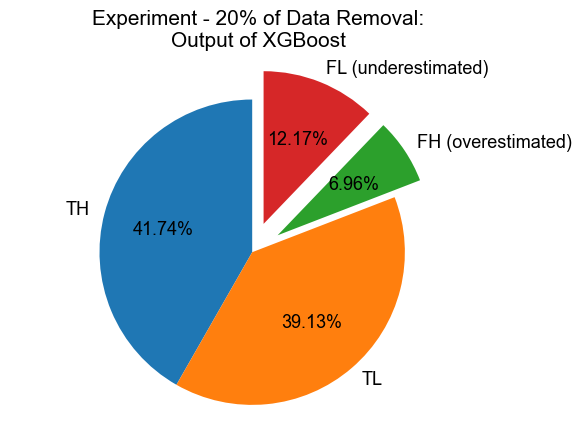

<Figure size 1920x1440 with 0 Axes>

In [37]:
labels = 'TH', 'TL', 'FH (overestimated)', 'FL (underestimated)'
sizes = [96, 90, 16, 28]
explode = (0, 0, 0.2, 0.2) 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%0.2f%%' ,startangle=90, textprops={'fontsize': 13})
plt.title("Experiment - 20% of Data Removal:\nOutput of XGBoost",fontsize = 15)
plt.figure(dpi=300)
ax1.axis('equal') 
plt.show()

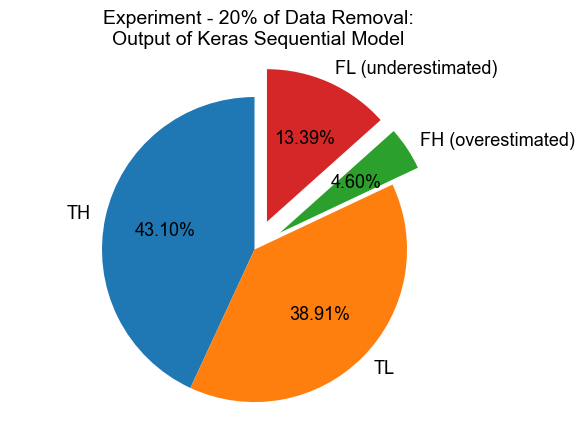

<Figure size 1920x1440 with 0 Axes>

In [38]:
labels = 'TH', 'TL', 'FH (overestimated)', 'FL (underestimated)'
sizes = [103, 93, 11, 32]
explode = (0, 0, 0.2, 0.2) 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%0.2f%%' ,startangle=90, textprops={'fontsize': 13})
plt.title("Experiment - 20% of Data Removal:\nOutput of Keras Sequential Model",fontsize = 14)
plt.figure(dpi=300)
ax1.axis('equal') 
plt.show()

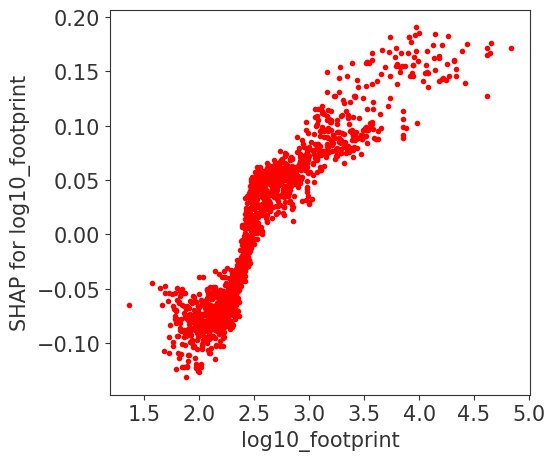

In [351]:
shap.dependence_plot("log10_footprint", shap_values[0], X, interaction_index=None, show=False, color="red", ax=None)
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
plt.xlabel('log10_footprint',fontsize=15)
plt.ylabel('SHAP for log10_footprint',fontsize=15)
plt.show()

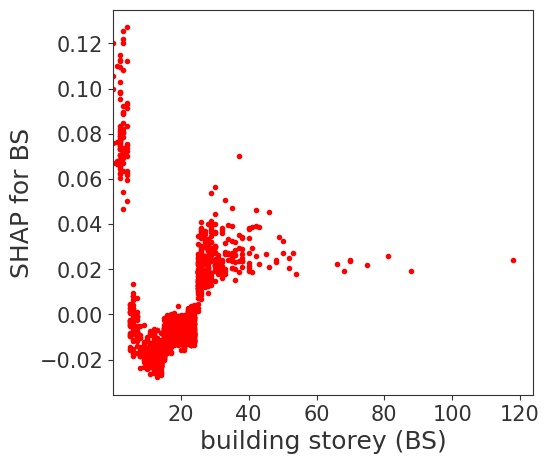

In [352]:
shap.dependence_plot("BS", shap_values[0], X, xmin=0.01, interaction_index=None, show=False, color="red", ax=None)

plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
plt.xlabel('building storey (BS)',fontsize=18)
plt.ylabel('SHAP for BS',fontsize=18)
plt.show()

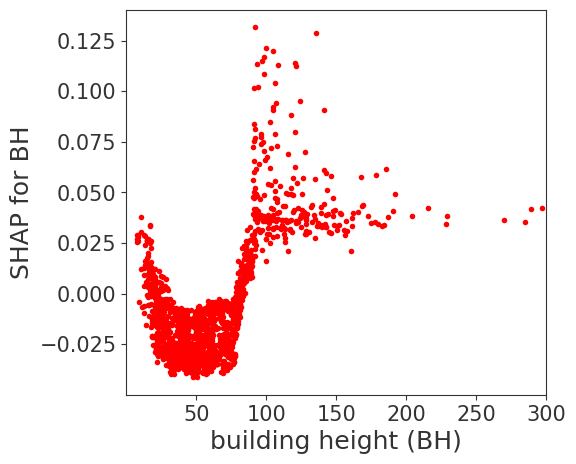

In [353]:
shap.dependence_plot("BH", shap_values[0], X, xmin=0.01, xmax = 300, interaction_index=None, show=False, color="red", ax=None)

plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
plt.xlabel('building height (BH)',fontsize=18)
plt.ylabel('SHAP for BH',fontsize=18)
plt.show()

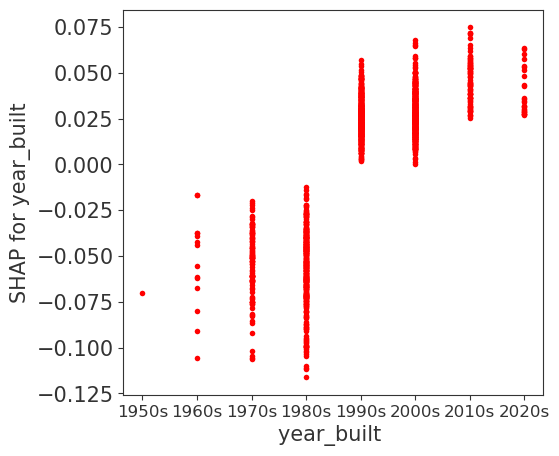

In [354]:
shap.dependence_plot("year_built", shap_values[0], X, interaction_index=None, show=False, ax=None, color="red")


plt.subplots_adjust(left=0.2,right=0.9)

plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [1,2,3,4,5,6,7,8]
label = ['1950s','1960s','1970s','1980s','1990s','2000s','2010s','2020s']
plt.xticks(x,label, fontsize=12)
plt.yticks(fontsize=15)


plt.xlabel('year_built ',fontsize=15)
plt.ylabel('SHAP for year_built',fontsize=15)
plt.show()

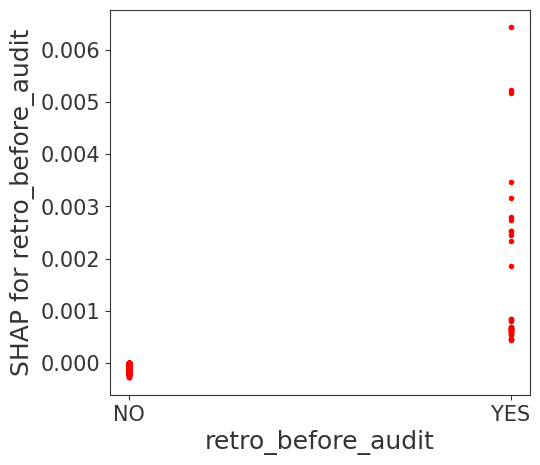

In [177]:
shap.dependence_plot("retro_before_audit", shap_values[0], X, interaction_index=None, show=False, ax=None, color="red")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)

plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)

plt.xlabel('retro_before_audit',fontsize=18)
plt.ylabel('SHAP for retro_before_audit',fontsize=18)
plt.show()

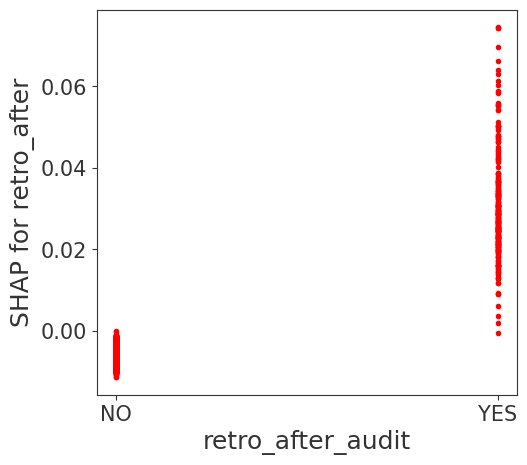

In [180]:
shap.dependence_plot("retro_after_audit", shap_values[0], X, interaction_index=None, show=False, ax=None, color="red")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)

plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)

plt.xlabel('retro_after_audit',fontsize=18)
plt.ylabel('SHAP for retro_after',fontsize=18)
plt.show()

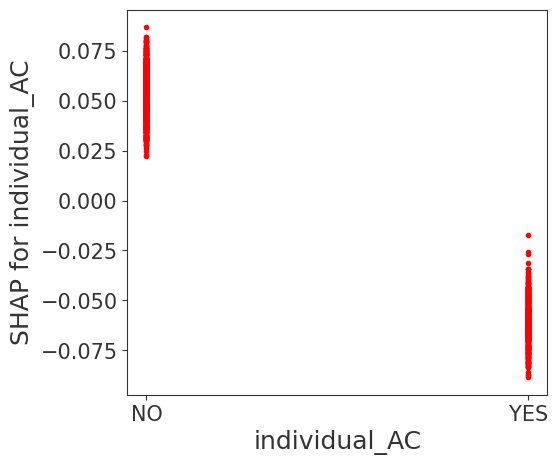

In [235]:
shap.dependence_plot("individual_AC", shap_values[0], X, interaction_index=None, show=False, ax=None, color="red")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)
plt.xlabel('individual_AC',fontsize=18)
plt.ylabel('SHAP for individual_AC',fontsize=18)
plt.show()

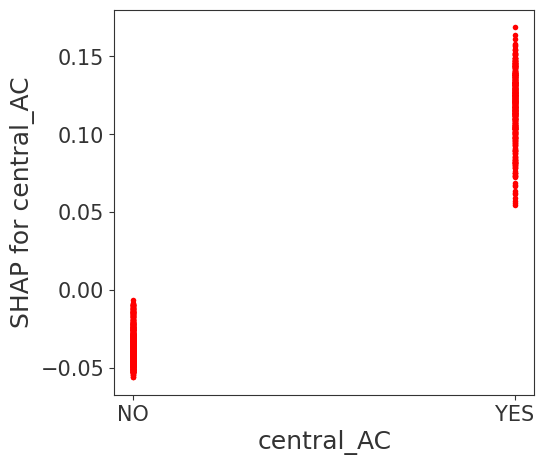

In [234]:
shap.dependence_plot("central_AC", shap_values[0], X, interaction_index=None, show=False, ax=None, color="red")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)
plt.xlabel('central_AC',fontsize=18)
plt.ylabel('SHAP for central_AC',fontsize=18)
plt.show()

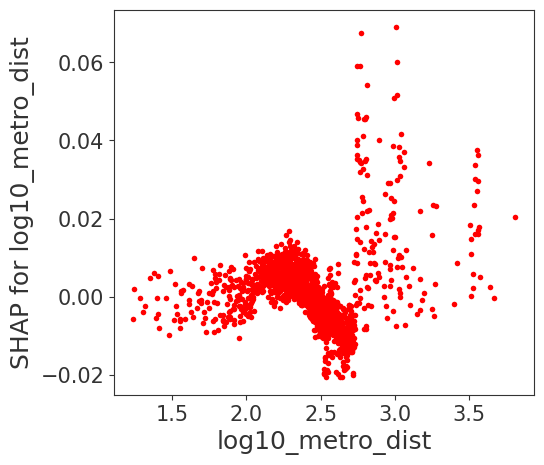

In [355]:
shap.dependence_plot("log10_metro_dist", shap_values[0], X , interaction_index=None, show=False, ax=None, color="red")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xlabel('log10_metro_dist',fontsize=18)
plt.ylabel('SHAP for log10_metro_dist',fontsize=18)
plt.show()

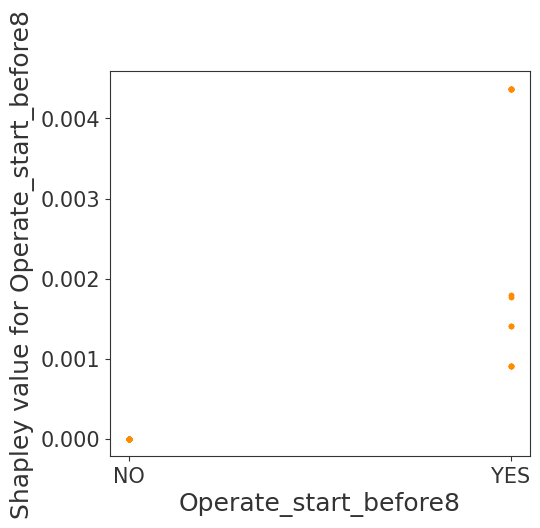

In [55]:
shap.dependence_plot("Operate_start_before8", shap_values[0], X, interaction_index=None, show=False, ax=None, color="darkorange")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)
plt.xlabel('Operate_start_before8',fontsize=18)
plt.ylabel('Shapley value for Operate_start_before8',fontsize=18)
plt.show()

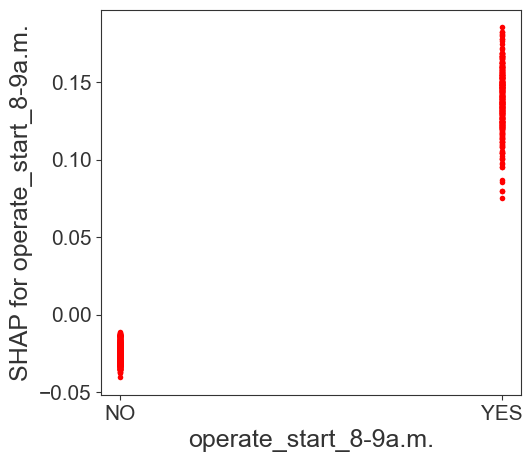

In [244]:
shap.dependence_plot("operate_start_8_9", shap_values[0], X, interaction_index=None, show=False, ax=None, color="red")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)
plt.xlabel('operate_start_8-9a.m.',fontsize=18)
plt.ylabel('SHAP for operate_start_8-9a.m.',fontsize=18)
plt.show()

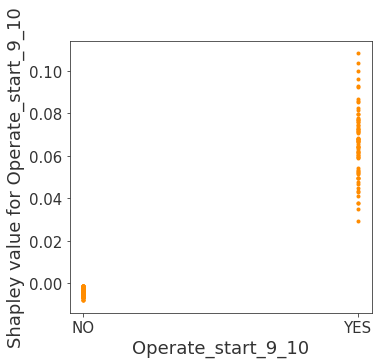

In [114]:
shap.dependence_plot("Operate_start_9_10", shap_values[0], X, interaction_index=None, show=False, ax=None, color="darkorange")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)
plt.xlabel('Operate_start_9_10',fontsize=18)
plt.ylabel('Shapley value for Operate_start_9_10',fontsize=18)
plt.show()

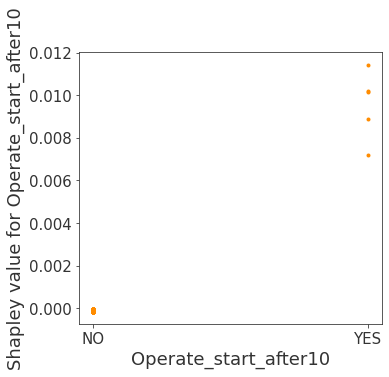

In [115]:
shap.dependence_plot("Operate_start_after10", shap_values[0], X, interaction_index=None, show=False, ax=None, color="darkorange")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)
plt.xlabel('Operate_start_after10',fontsize=18)
plt.ylabel('Shapley value for Operate_start_after10',fontsize=18)
plt.show()

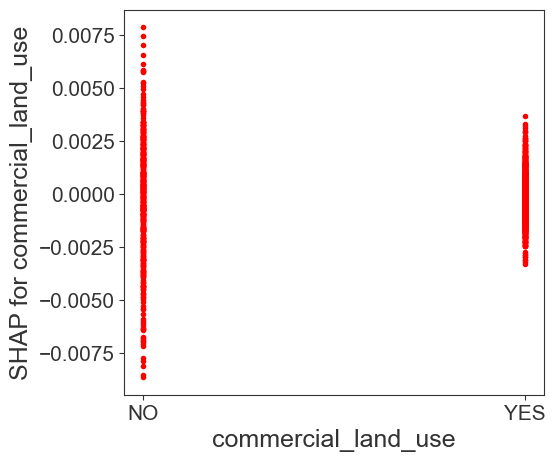

In [243]:
shap.dependence_plot("commercial_land_use", shap_values[0], X, interaction_index=None, show=False, ax=None, color="red")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)
plt.xlabel('commercial_land_use',fontsize=18)
plt.ylabel('SHAP for commercial_land_use',fontsize=18)
plt.show()

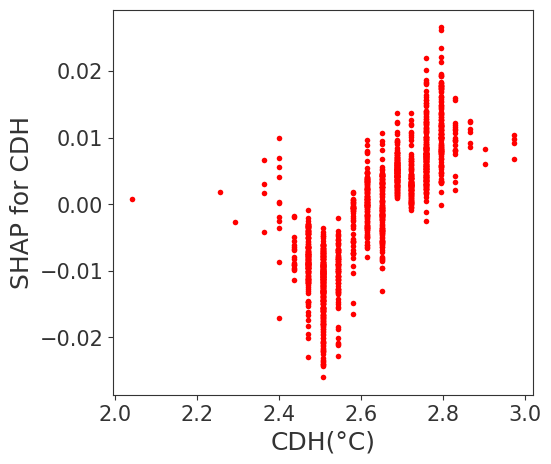

In [356]:
shap.dependence_plot("CDH", shap_values[0], X, interaction_index=None, show=False, ax=None, color="red")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xlabel('CDH(°C)',fontsize=18)
plt.ylabel('SHAP for CDH',fontsize=18)
plt.show()

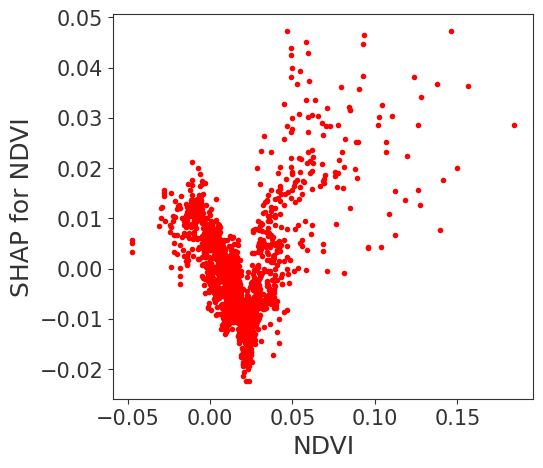

In [357]:
shap.dependence_plot("NDVI", shap_values[0], X, interaction_index=None, show=False, ax=None, color="red")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xlabel('NDVI',fontsize=18)
plt.ylabel('SHAP for NDVI',fontsize=18)
plt.show()

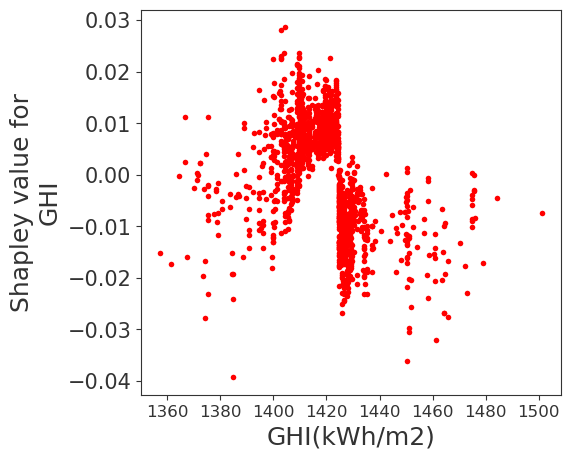

In [358]:
shap.dependence_plot("GHI", shap_values[0], X, interaction_index=None, show=False, ax=None, color="red")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xticks(fontsize=12)
plt.xlabel('GHI(kWh/m2)',fontsize=18)
plt.ylabel('Shapley value for\nGHI',fontsize=18)
plt.show()

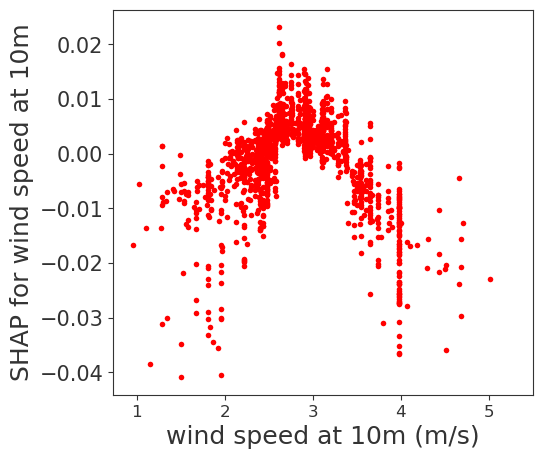

In [359]:
shap.dependence_plot("wind_speed_10m", shap_values[0], X, xmax =5.5, interaction_index=None, show=False, ax=None, color="red")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xticks(fontsize=12)
plt.xlabel('wind speed at 10m (m/s)',fontsize=18)
plt.ylabel('SHAP for wind speed at 10m',fontsize=18)
plt.show()

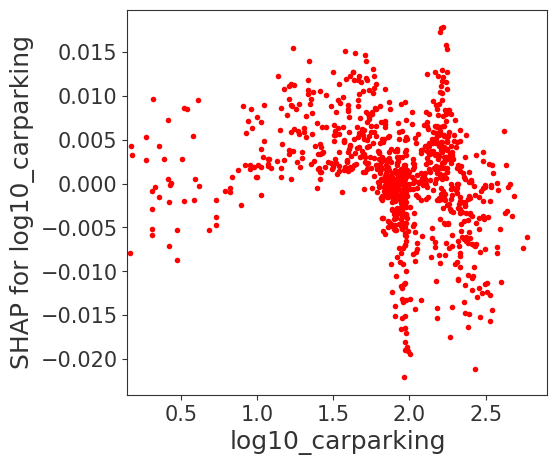

In [360]:
shap.dependence_plot("log10_carparking", shap_values[0], X, xmin=0.15, interaction_index=None, show=False, ax=None, color="red")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xlabel('log10_carparking',fontsize=18)
plt.ylabel('SHAP for log10_carparking',fontsize=18)
plt.show()

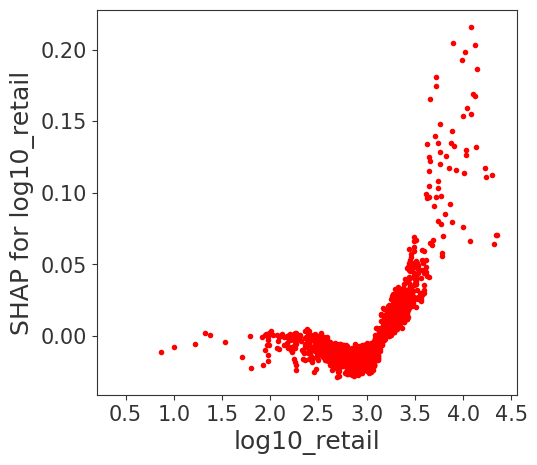

In [361]:
shap.dependence_plot("log10_retail", shap_values[0], X, xmin=0.2, interaction_index=None, show=False, ax=None, color="red")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xlabel('log10_retail',fontsize=18)
plt.ylabel('SHAP for log10_retail',fontsize=18)
plt.show()

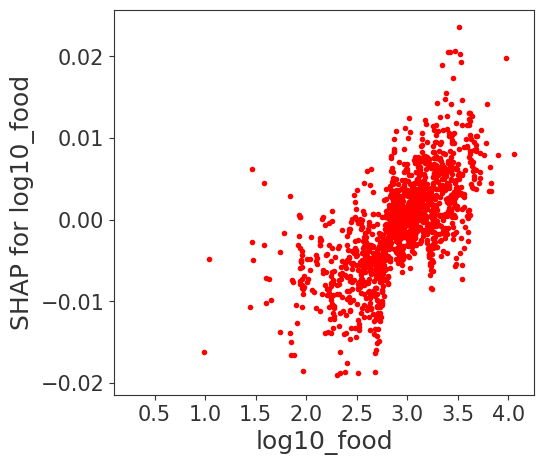

In [365]:
shap.dependence_plot("log10_food", shap_values[0], X, xmin=0.1, interaction_index=None, show=False, ax=None, color="red")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xlabel('log10_food',fontsize=18)
plt.ylabel('SHAP for log10_food',fontsize=18)
plt.show()

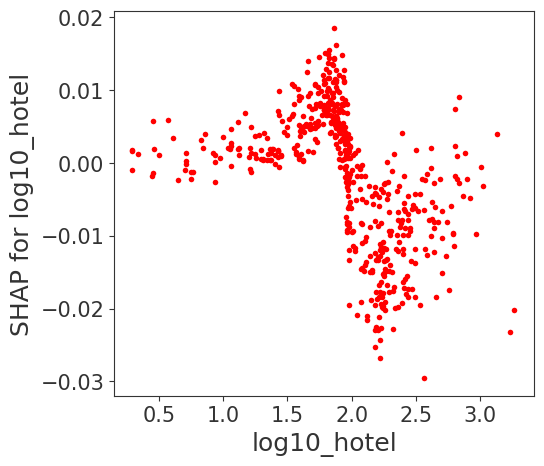

In [366]:
shap.dependence_plot("log10_hotel", shap_values[0], X, interaction_index=None, xmin = 0.15, show=False, ax=None, color="RED")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xlabel('log10_hotel',fontsize=18)
plt.ylabel('SHAP for log10_hotel',fontsize=18)
plt.show()

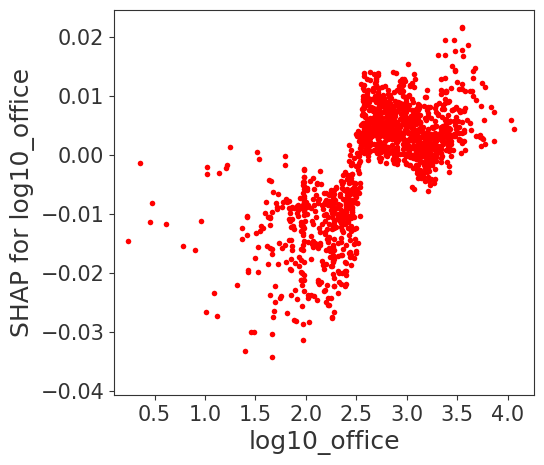

In [367]:
shap.dependence_plot("log10_office", shap_values[0], X,  xmin = 0.1,interaction_index=None, show=False, ax=None, color="red")
plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.xlabel('log10_office',fontsize=18)
plt.ylabel('SHAP for log10_office',fontsize=18)
plt.show()